# This file encompasses the Spent Prediction segment of the project.
<P>Imagine you are working for a financial institution, and your task is to detect anomalies in financial transactions to identify potential fraudulent activities. You are provided with a dataset containing various parameters related to financial transactions. Your goal is to design amount spend for the month of June</P>

## Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #This is to analyze the correlation
from statsmodels.tsa.stattools import adfuller #This is to identify if the data is stanorary or not
from statsmodels.tsa.ar_model import AutoReg ## This is for the model I am going to implement Later

### I am gonna cut to the chase as EDA is done in part 1 of the assignment.

In [2]:
df = pd.read_csv('financial_anomaly_data.csv') 

In [3]:
df.head()

,Timestamp,TransactionID,AccountID,Amount,Merchant,TransactionType,Location
0,01-01-2023 08:00,TXN1127,ACC4,95071.92,MerchantH,Purchase,Tokyo
1,01-01-2023 08:01,TXN1639,ACC10,15607.89,MerchantH,Purchase,London
2,01-01-2023 08:02,TXN872,ACC8,65092.34,MerchantE,Withdrawal,London
3,01-01-2023 08:03,TXN1438,ACC6,87.87,MerchantE,Purchase,London
4,01-01-2023 08:04,TXN1338,ACC6,716.56,MerchantI,Purchase,Los Angeles


In [4]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format="%d-%m-%Y %H:%M")
df['Date'] = df['Timestamp'].dt.date

In [5]:
df.head()

,Timestamp,TransactionID,AccountID,Amount,Merchant,TransactionType,Location,Date
0,2023-01-01 08:00:00,TXN1127,ACC4,95071.92,MerchantH,Purchase,Tokyo,2023-01-01
1,2023-01-01 08:01:00,TXN1639,ACC10,15607.89,MerchantH,Purchase,London,2023-01-01
2,2023-01-01 08:02:00,TXN872,ACC8,65092.34,MerchantE,Withdrawal,London,2023-01-01
3,2023-01-01 08:03:00,TXN1438,ACC6,87.87,MerchantE,Purchase,London,2023-01-01
4,2023-01-01 08:04:00,TXN1338,ACC6,716.56,MerchantI,Purchase,Los Angeles,2023-01-01


In [6]:
df.drop(['Timestamp', 'TransactionID', 'AccountID', 'Merchant',
       'TransactionType', 'Location'], axis = 1, inplace= True)

In [7]:
df.head()

,Amount,Date
0,95071.92,2023-01-01
1,15607.89,2023-01-01
2,65092.34,2023-01-01
3,87.87,2023-01-01
4,716.56,2023-01-01


### I can see there are many transactions in a single day, so I will group the data by date and add the corresponding amount

In [8]:
data = df.groupby('Date')['Amount'].sum().reset_index()

In [9]:
data.head()

,Date,Amount
0,2023-01-01,47556159.41
1,2023-01-02,70569287.09
2,2023-01-03,73747428.12
3,2023-01-04,73637800.99
4,2023-01-05,73513355.48


In [10]:
data.shape

(151, 2)

In [11]:
# Setting Index as Date
data.set_index('Date', inplace=True)

In [12]:
data.head()

,Amount
Date,
2023-01-01,47556159.41
2023-01-02,70569287.09
2023-01-03,73747428.12
2023-01-04,73637800.99
2023-01-05,73513355.48


<Axes: xlabel='Date'>

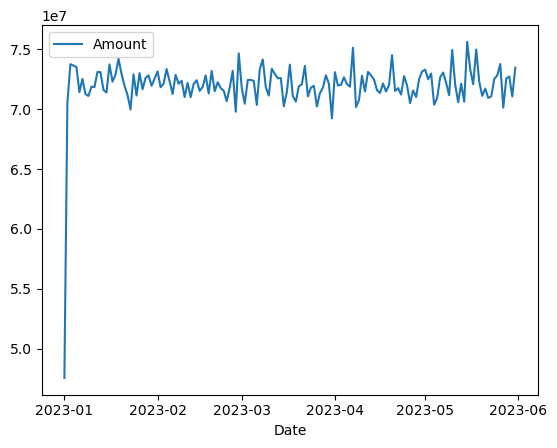

In [13]:
#Ploting the data to understand any repetations
data.plot()

In [14]:
# By observing the plot and data, 2023-01-01 has very less amount of transations compared to other days 
# So, Im gonna consider it as an outlier to make model better

<Axes: xlabel='Date'>

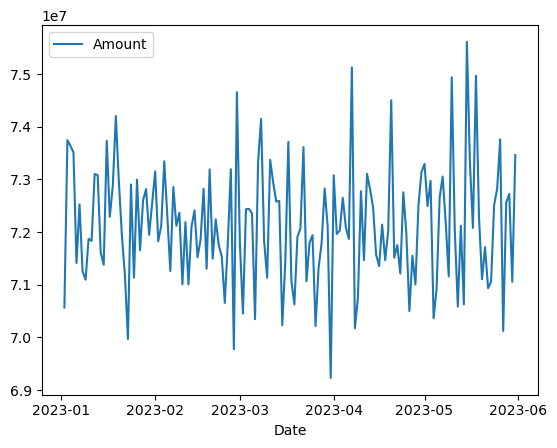

In [15]:
data[1:].plot() # without 2023-01-01

In [16]:
#By looking at the graph I can say its a statonary Data, but I am going to confirm it with Stastics
result = adfuller(data, autolag='AIC')

# Extract and print the results
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -8.009187816461706
p-value: 2.2250393797405204e-12
Critical Values: {'1%': -3.4756368462466662, '5%': -2.8814104466172608, '10%': -2.5773652982553568}


In [17]:
if result[1] <= 0.05:
    print("Reject the null hypothesis; the time series is likely stationary.")
else:
    print("Fail to reject the null hypothesis; the time series is likely non-stationary.")

Reject the null hypothesis; the time series is likely stationary.


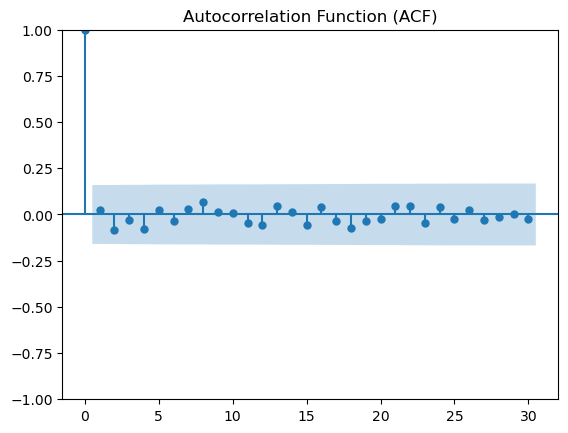

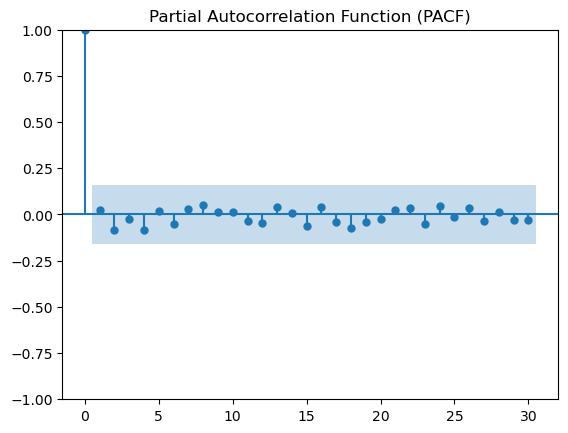

In [18]:
# Making plots to understand Corellations
plot_acf(data, lags=30)
plt.title('Autocorrelation Function (ACF)')
plt.show()

plot_pacf(data, lags=30)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

In [19]:
# Splitting data to validate the model
train = data[:len(data) - 7]
test = data[len(data) - 7: ]

# Model Implementation

In [20]:
model=AutoReg(train,lags=30).fit()

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [21]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                 Amount   No. Observations:                  144
Model:                    AutoReg(30)   Log Likelihood               -1737.226
Method:               Conditional MLE   S.D. of innovations        1004381.412
Date:                Tue, 05 Dec 2023   AIC                           3538.451
Time:                        00:11:01   BIC                           3626.010
Sample:                    01-31-2023   HQIC                          3573.986
                         - 05-24-2023                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         1.5e+08   6.01e+07      2.496      0.013    3.22e+07    2.68e+08
Amount.L1     -0.1453      0.093     -1.554      0.120      -0.328       0.038
Amount.L2     -0.2130      0.094     -2.267      0.023      -0.397      -0.029
Amount.L3      0.0893      0.096      0.931      0.352      -0.099       0.277
Amount.L4     -0.1361      0.096     -1.417      0.157      -0.324       0.052
Amount.L5      0.0235      0.097      0.243      0.808      -0.166       0.213
Amount.L6     -0.1066      0.096     -1.109      0.267      -0.295       0.082
Amount.L7      0.0089      0.098      0.090      0.928      -0.184       0.201
Amount.L8      0.0684      0.097      0.703      0.482      -0.122       0.259
Amount.L9      0.1058      0.098      1.079      0.280      -0.086       0.298
Amount.L10     0.0174      0.103      0.169      0.866      -0.185       0.220
Amount.L11    -0.1056      0.103     -1.022      0.307      -0.308       0.097
Amount.L12    -0.1470      0.103     -1.428      0.153      -0.349       0.055
Amount.L13    -0.0345      0.100     -0.343      0.731      -0.231       0.162
Amount.L14    -0.0718      0.098     -0.730      0.465      -0.264       0.121
Amount.L15    -0.0869      0.101     -0.863      0.388      -0.284       0.110
Amount.L16     0.1187      0.099      1.197      0.231      -0.076       0.313
Amount.L17     0.0323      0.099      0.327      0.743      -0.161       0.226
Amount.L18    -0.0278      0.099     -0.280      0.779      -0.222       0.167
Amount.L19    -0.0798      0.099     -0.808      0.419      -0.273       0.114
Amount.L20    -0.0921      0.098     -0.936      0.349      -0.285       0.101
Amount.L21     0.0052      0.099      0.052      0.958      -0.189       0.199
Amount.L22    -0.1160      0.099     -1.169      0.242      -0.311       0.079
Amount.L23    -0.2001      0.100     -2.007      0.045      -0.395      -0.005
Amount.L24    -0.0418      0.102     -0.409      0.683      -0.243       0.159
Amount.L25    -0.0499      0.102     -0.489      0.625      -0.250       0.150
Amount.L26     0.0651      0.103      0.635      0.526      -0.136       0.266
Amount.L27    -0.0028      0.101     -0.027      0.978      -0.200       0.194
Amount.L28     0.1329      0.100      1.333      0.183      -0.063       0.328
Amount.L29    -0.0622      0.098     -0.636      0.525      -0.254       0.129
Amount.L30    -0.0288      0.043     -0.662      0.508      -0.114       0.056
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.0589           -0.0000j            1.0589           -0.5000
AR.2            -1.0286           -0.2613j            1.0613           -0.4604
AR.3            -1.0286           +0.2613j            1.0613            0.4604
AR

In [22]:
# Predicting on the training set 
pred = model.predict(start = len(train), end = len(data) - 1, dynamic = False)

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


In [23]:
pred

2023-05-25    7.199973e+07
2023-05-26    7.244766e+07
2023-05-27    7.272430e+07
2023-05-28    7.190989e+07
2023-05-29    7.138179e+07
2023-05-30    7.045915e+07
2023-05-31    7.256400e+07
Freq: D, dtype: float64

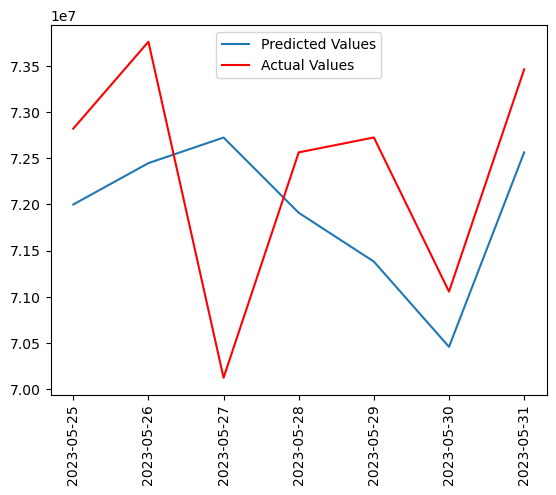

In [24]:
# Ploting preds vs actual amounts
plt.plot(pred, label='Predicted Values')
plt.plot(test, color='red', label='Actual Values')

plt.xticks(rotation=90)

# Adding legends
plt.legend()
plt.show()

## Model Evaluation

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(test, pred))
print(f'RMSE: {rmse}')

# Calculate MAE (Mean Absolute Error)
mae = mean_absolute_error(test, pred)
print(f'MAE: {mae}')

# Calculate MAPE (Mean Absolute Percentage Error)
mape = mean_absolute_percentage_error(test, pred)
print(f'MAPE: {mape}%')


RMSE: 1339202.367144725
MAE: 1175387.373340315
MAPE: 0.016325734436854835%


# Predictions for the Month of June

In [26]:
pred_june = model.predict(start = len(train), end = len(data) - 1 + 30, dynamic = False)
print(pred_june)

2023-05-25    7.199973e+07
2023-05-26    7.244766e+07
2023-05-27    7.272430e+07
2023-05-28    7.190989e+07
2023-05-29    7.138179e+07
2023-05-30    7.045915e+07
2023-05-31    7.256400e+07
2023-06-01    7.214203e+07
2023-06-02    7.131680e+07
2023-06-03    7.328467e+07
2023-06-04    7.228582e+07
2023-06-05    7.211739e+07
2023-06-06    7.173698e+07
2023-06-07    7.084985e+07
2023-06-08    7.159823e+07
2023-06-09    7.156488e+07
2023-06-10    7.217017e+07
2023-06-11    7.254450e+07
2023-06-12    7.297645e+07
2023-06-13    7.268689e+07
2023-06-14    7.204444e+07
2023-06-15    7.189590e+07
2023-06-16    7.167918e+07
2023-06-17    7.181068e+07
2023-06-18    7.198691e+07
2023-06-19    7.237184e+07
2023-06-20    7.243105e+07
2023-06-21    7.286771e+07
2023-06-22    7.240760e+07
2023-06-23    7.152519e+07
2023-06-24    7.196171e+07
2023-06-25    7.168512e+07
2023-06-26    7.174691e+07
2023-06-27    7.216007e+07
2023-06-28    7.247404e+07
2023-06-29    7.269640e+07
2023-06-30    7.225522e+07
F

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


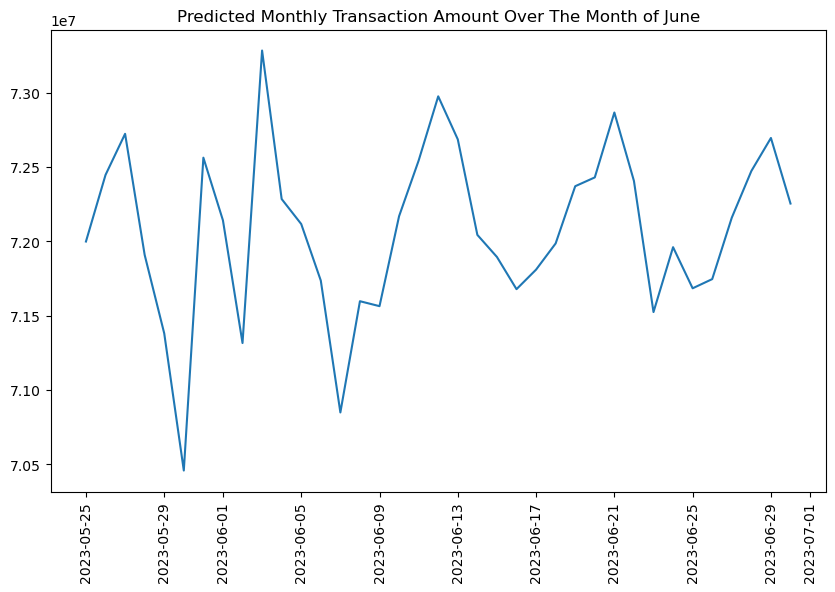

In [27]:
# Ploting for abount the Month of June
plt.figure(figsize=(10, 6))
plt.plot(pred_june)
plt.xticks(rotation=90)
plt.title('Predicted Monthly Transaction Amount Over The Month of June')
plt.show()